# 06 — Fine Tuning und Robustheit

## Ziel
Dieses Notebook beschreibt den Prozess der Feinabstimmung unseres Modells und die Bewertung seiner Robustheit gegenüber verschiedenen Störungen in den Eingabedaten.

## Imports und Setup

In [1]:
import importlib
import numpy as np
import pandas as pd
from sklearn.metrics import silhouette_score, davies_bouldin_score

import utils.paths as paths
from utils.data_loader import load_all
from utils.reporting import ensure_dirs, save_joblib, save_json
from utils.config import RANDOM_SEED, ALLOW_LEAKY_FEATURES

# Import modules (NOT classes) so reload works
import utils.tasks.success_pct as success_pct
import utils.tasks.success_residual as success_residual
import utils.tasks.hit as hit
import utils.tasks.moods as moods
import utils.tasks.ranker as ranker
import utils.tasks.artist_trajectory as artist_trajectory
import utils.tasks.artist_clustering as artist_clustering
import utils.tasks.track_similarity as track_similarity

# Reload modules
importlib.reload(success_pct)
importlib.reload(success_residual)
importlib.reload(hit)
importlib.reload(moods)
importlib.reload(ranker)
importlib.reload(artist_trajectory)
importlib.reload(artist_clustering)
importlib.reload(track_similarity)

# Keep references to CLASSES (optional)
SuccessPctTrainer = success_pct.SuccessPctTrainer
SuccessResidualTrainer = success_residual.SuccessResidualTrainer
HitTrainer = hit.HitTrainer
MoodTrainer = moods.MoodTrainer
RankerTrainer = ranker.RankerTrainer
ArtistTrajectoryTrainer = artist_trajectory.ArtistTrajectoryTrainer
ArtistClusteringRunner = artist_clustering.ArtistClusteringRunner
TrackSimilarityRunner = track_similarity.TrackSimilarityRunner

from utils.datasets import (
    build_success_pct_dataset,
    build_success_residual_dataset,
    build_hit_dataset,
    build_mood_dataset,
)

# Reload paths if you need
importlib.reload(paths)

SAMPLE_NAME = paths.load_sample_name()
PATHS = paths.make_paths(SAMPLE_NAME)
paths.ensure_dirs(PATHS)




## Load Data

In [2]:
data = load_all(PATHS.input_targets_path)

ds_pct  = build_success_pct_dataset(data.X_track, data.track_df, data.y_success_pct)
ds_res  = build_success_residual_dataset(data.X_track, data.track_df, data.y_success_residual)
ds_hit  = build_hit_dataset(data.X_track, data.track_df, data.y_hit)
ds_mood = build_mood_dataset(data.X_track, data.track_df, data.Y_mood)

ap = data.artist_panel.sort_values("release_month_ts").reset_index(drop=True)

y_artist_growth = ap["y_growth"].astype(float)
y_artist_breakout = ap["y_breakout"].astype(int)

X_artist_panel = ap.select_dtypes(include=["number", "bool"]).drop(
    columns=["y_growth", "y_breakout", "release_month_ts", "artist_id"],
    errors="ignore"
).fillna(0)



## Tuning: Success Percentile innerhalb der Kohorte (Regression)

Ziel: Vorhersage der relativen Erfolgsposition eines Tracks innerhalb seiner Release-Kohorte (0–100).

Optimierungsziel:
- **MAE auf dem Validierungsset minimieren**, da die Skala interpretierbar ist (Punkte im Perzentilraum).

Hinweis:
- Wir nutzen einen **kohortenbasierten Zeitsplit**, um Leakage in die Zukunft zu vermeiden.
- Optional kann XGBoost auf **GPU (CUDA)** laufen (`device="cuda"`).


In [3]:
pct_trainer = SuccessPctTrainer(seed=RANDOM_SEED)

best_pct = pct_trainer.tune(
    ds_pct,
    n_trials=20,
    device="gpu",   # oder "cpu"
)

best_pct

[I 2026-01-19 10:18:28,852] A new study created in memory with name: no-name-90b5add9-4f18-4d6d-8bb1-742465665bcd
C:\GitHub\data-science\.venv\Lib\site-packages\xgboost\core.py:774: UserWarning: [10:23:09] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:62: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)
[I 2026-01-19 10:23:10,374] Trial 0 finished with value: 20.98596679545327 and parameters: {'learning_rate': 0.010938159489609748, 'max_depth': 4, 'min_child_weight': 4.9476908246597375, 'subsample': 0.8054781273724446, 'colsample_bytree': 0.8094510452076932, 'reg_lambda': 1.0846762657821416, 'reg_alpha'

{'best_params': {'learning_rate': 0.0760894616779757,
  'max_depth': 7,
  'min_child_weight': 38.7402309132371,
  'subsample': 0.8846924685095854,
  'colsample_bytree': 0.7576873575824754,
  'reg_lambda': 1.9600508809770578,
  'reg_alpha': 0.038157732945760754,
  'gamma': 1.4078253427785505,
  'max_leaves': 68},
 'best_val_mae': 20.761695351473165,
 'device': 'gpu'}

## Tuning: Success Residual innerhalb der Kohorte (Regression)

Ziel: Modellierung von **Über- oder Unterperformance** relativ zur Kohorte (Residual statt absoluter Erfolg).

Optimierungsziel:
- **MAE auf dem Validierungsset minimieren** (robust, gut interpretierbar).

Hinweis:
- Residual-Targets sind oft verrauscht → Regularisierung ist besonders wichtig.
- Kohortenbasierter Zeitsplit verhindert ungewollte Zukunftsinformation.


In [4]:
res_trainer = SuccessResidualTrainer(seed=RANDOM_SEED)

best_res = res_trainer.tune(
    ds_res,
    n_trials=20,
    device="cuda",   # oder "cpu"
)

best_res



[I 2026-01-19 10:53:43,064] A new study created in memory with name: no-name-5f8e16fa-fda2-4264-b0a4-dd72b87a6dbd
[I 2026-01-19 10:57:56,042] Trial 0 finished with value: 10.54355239868164 and parameters: {'learning_rate': 0.03083433558079921, 'max_depth': 4, 'min_child_weight': 18.08282274350235, 'subsample': 0.8695083613760101, 'colsample_bytree': 0.7240887634637283, 'reg_lambda': 1.1066896498560252, 'reg_alpha': 0.002790048221660378, 'gamma': 0.4379445401207247, 'max_leaves': 158}. Best is trial 0 with value: 10.54355239868164.
[I 2026-01-19 11:00:37,278] Trial 1 finished with value: 10.500831604003906 and parameters: {'learning_rate': 0.03373862405467692, 'max_depth': 4, 'min_child_weight': 2.272502487079964, 'subsample': 0.7092816518730193, 'colsample_bytree': 0.9249943341370293, 'reg_lambda': 34.0742307914149, 'reg_alpha': 0.08642977616489543, 'gamma': 1.033779290962123, 'max_leaves': 176}. Best is trial 1 with value: 10.500831604003906.
[I 2026-01-19 11:02:42,352] Trial 2 finish

{'best_params': {'learning_rate': 0.05334966753883901,
  'max_depth': 5,
  'min_child_weight': 37.658243691328586,
  'subsample': 0.8172428159131311,
  'colsample_bytree': 0.7848958013379582,
  'reg_lambda': 2.871146009563806,
  'reg_alpha': 0.0010308298641305866,
  'gamma': 1.5256951716255802,
  'max_leaves': 51},
 'best_val_mae': 10.447340965270996,
 'device': 'cuda'}

## Tuning: Hit Prediction (Binary Classification)

Ziel: Vorhersage, ob ein Track als „Hit“ gilt.

Optimierungsziel:
- **PR-AUC auf dem Validierungsset maximieren**
  (bei unausgeglichenen Klassen oft sinnvoller als ROC-AUC).

Zusatz:
- Der finale **Threshold** (für F1) wird später auf der Validierung optimiert (wie im Training-Notebook).
- GPU ist möglich (XGBoost).


In [5]:
hit_trainer = HitTrainer(seed=RANDOM_SEED)

best_hit = hit_trainer.tune(
    ds_hit,
    n_trials=30,
    device="cuda",   # oder "cpu"
)

best_hit


[I 2026-01-19 11:35:23,199] A new study created in memory with name: no-name-1c9b33c0-a97c-44f2-aa7f-2b7b59c6423c
[I 2026-01-19 11:35:36,953] Trial 0 finished with value: 0.5382929165734426 and parameters: {'learning_rate': 0.04722503085588173, 'max_depth': 6, 'subsample': 0.6711782376854544, 'colsample_bytree': 0.8513599274052017, 'min_child_weight': 2.5901224112813304, 'reg_lambda': 8.158215665530365, 'reg_alpha': 0.001077185890896497, 'gamma': 0.771794003476411, 'scale_pos_weight': 4.854528223024694, 'max_delta_step': 7}. Best is trial 0 with value: 0.5382929165734426.
[I 2026-01-19 11:36:09,346] Trial 1 finished with value: 0.5337103243001632 and parameters: {'learning_rate': 0.026433104876954366, 'max_depth': 3, 'subsample': 0.6507951834143598, 'colsample_bytree': 0.7826289964184034, 'min_child_weight': 3.052486049028195, 'reg_lambda': 9.870110319596101, 'reg_alpha': 0.00012783677250158127, 'gamma': 0.9074709945883355, 'scale_pos_weight': 3.8992887682966457, 'max_delta_step': 2}. 

{'best_params': {'learning_rate': 0.05254048461654104,
  'max_depth': 7,
  'subsample': 0.9171144642159443,
  'colsample_bytree': 0.7014575933387529,
  'min_child_weight': 17.47680727496228,
  'reg_lambda': 4.9348417833016835,
  'reg_alpha': 0.04816342439289589,
  'gamma': 1.6372915433462887,
  'scale_pos_weight': 4.14886009630001,
  'max_delta_step': 10},
 'best_val_pr_auc': 0.5483996362836441,
 'device': 'cuda'}

## Tuning: Mood Prediction (Multi-Label)

Ziel: Mehrere Mood-Labels pro Track (z.B. happy, sad, chill …).

Optimierungsziel:
- **Micro-F1 auf dem Validierungsset maximieren**
  (gute Standardmetrik bei Multi-Label, weil sie alle Entscheidungen gemeinsam bewertet).

Hinweis:
- Viele sklearn-Modelle laufen CPU-basiert; GPU ist hier meistens nicht relevant.
- Thresholds können später pro Label separat optimiert werden.


In [6]:
mood_trainer = MoodTrainer(seed=RANDOM_SEED)

best_mood = mood_trainer.tune(
    ds_mood,
    n_trials=30,
)

best_mood


[I 2026-01-19 11:43:46,269] A new study created in memory with name: no-name-b7a3110c-2397-4d65-b1a8-16d394ac5098
[I 2026-01-19 11:44:05,039] Trial 0 finished with value: 0.021889400921658985 and parameters: {'alpha': 3.2888152233597054e-05, 'loss': 'modified_huber', 'penalty': 'l1', 'threshold': 0.4820367076162725}. Best is trial 0 with value: 0.021889400921658985.
[I 2026-01-19 11:44:08,898] Trial 1 finished with value: 0.2205441687642335 and parameters: {'alpha': 0.0003200147972807627, 'loss': 'modified_huber', 'penalty': 'l2', 'threshold': 0.22506788018616453}. Best is trial 1 with value: 0.2205441687642335.
[I 2026-01-19 11:44:13,841] Trial 2 finished with value: 0.19736355796476532 and parameters: {'alpha': 1.6380514931128714e-05, 'loss': 'modified_huber', 'penalty': 'elasticnet', 'l1_ratio': 0.5951737537430581, 'threshold': 0.1064107328195732}. Best is trial 1 with value: 0.2205441687642335.
[I 2026-01-19 11:44:18,663] Trial 3 finished with value: 0.2082572159298502 and paramete

{'best_params': {'alpha': 0.0007797448935234654,
  'loss': 'modified_huber',
  'penalty': 'l1',
  'threshold': 0.7696896582649719},
 'best_val_micro_f1': 0.340953625081646}

## Tuning: Ranker (Learning-to-Rank)

Ziel: Tracks innerhalb einer Kohorte sinnvoll zu ranken (Top-K Qualität).

Optimierungsziel:
- **Mean NDCG@10 auf dem Validierungsset maximieren**.

Wichtig:
- Ranking benötigt eine saubere Gruppierung (z.B. pro `cohort_ym`).
- GPU ist möglich (XGBRanker).


In [7]:
rank_trainer = RankerTrainer(seed=RANDOM_SEED)

best_rank = rank_trainer.tune(
    ds_pct,        # typischerweise nutzt der Ranker das gleiche X, aber anderes Training/Grouping
    n_trials=30,
    device="cuda", # oder "cpu"
    k=10
)

best_rank


[I 2026-01-19 11:46:40,084] A new study created in memory with name: no-name-8bcd7512-7a4f-431c-b282-f87479c69928
[I 2026-01-19 11:46:52,193] Trial 0 finished with value: 0.22814324525324906 and parameters: {'learning_rate': 0.012351536199721859, 'max_depth': 3, 'min_child_weight': 7.665555737101866, 'subsample': 0.9412866984127681, 'colsample_bytree': 0.7469977861193016, 'reg_lambda': 6.673709793481175, 'reg_alpha': 0.0035979718602752123, 'gamma': 1.5010137949869227, 'max_leaves': 101}. Best is trial 0 with value: 0.22814324525324906.
[I 2026-01-19 11:47:15,130] Trial 1 finished with value: 0.3489532237399051 and parameters: {'learning_rate': 0.018316957239850953, 'max_depth': 7, 'min_child_weight': 28.736600237386938, 'subsample': 0.8953669633490231, 'colsample_bytree': 0.8054751723577873, 'reg_lambda': 13.314635648986325, 'reg_alpha': 0.0005649524938825148, 'gamma': 0.7476454285838601, 'max_leaves': 225}. Best is trial 1 with value: 0.3489532237399051.
[I 2026-01-19 11:47:28,164] Tr

{'best_params': {'learning_rate': 0.05911238217667713,
  'max_depth': 6,
  'min_child_weight': 30.85592557463312,
  'subsample': 0.68062883197796,
  'colsample_bytree': 0.729393441271066,
  'reg_lambda': 13.925025414544313,
  'reg_alpha': 0.2440246579118277,
  'gamma': 1.039472869038082,
  'max_leaves': 104},
 'best_val_mean_ndcg@k': 0.38673149408072777,
 'k': 10,
 'device': 'cuda'}

## Tuning: Artist Trajectory (Growth & Breakout)

Ziel: Künstlerentwicklung über Zeit modellieren.

Teilaufgaben:
- **Growth (Regression):** log1p-transformiertes Wachstum → **MAE minimieren**
- **Breakout (Binary):** Breakout-Event → **PR-AUC maximieren**

Hinweis:
- Zeitliche Sortierung ist Pflicht, damit der Split korrekt ist.
- GPU ist möglich (XGBoost).


In [8]:
artist_trainer = ArtistTrajectoryTrainer(seed=RANDOM_SEED)

best_artist = artist_trainer.tune(
    data.artist_panel,
    n_trials=30,
    device="cuda",   # oder "cpu"
)

best_artist


[I 2026-01-19 11:59:58,885] A new study created in memory with name: no-name-896a2fe8-c24e-4032-92d9-3657b4a5d129
[I 2026-01-19 12:00:00,072] Trial 0 finished with value: 0.44150175380576034 and parameters: {'n_estimators': 5746, 'learning_rate': 0.05932317678646927, 'max_depth': 2, 'subsample': 0.900616575742088, 'colsample_bytree': 0.8596201451108914, 'min_child_weight': 0.017060893583981745, 'reg_alpha': 1.09415755864617e-07, 'reg_lambda': 1.4928352435441677e-05}. Best is trial 0 with value: 0.44150175380576034.
[I 2026-01-19 12:00:03,949] Trial 1 finished with value: 0.4307889641237097 and parameters: {'n_estimators': 833, 'learning_rate': 0.001547524826755164, 'max_depth': 3, 'subsample': 0.8804249489101433, 'colsample_bytree': 0.7914509496962148, 'min_child_weight': 0.018365916484388463, 'reg_alpha': 7.766634627867034e-06, 'reg_lambda': 3.994026117898243e-07}. Best is trial 1 with value: 0.4307889641237097.
[I 2026-01-19 12:00:05,531] Trial 2 finished with value: 0.44093623331803

{'growth': {'best_params': {'n_estimators': 6178,
   'learning_rate': 0.18914030264923407,
   'max_depth': 6,
   'subsample': 0.704500699230627,
   'colsample_bytree': 0.9968281734219846,
   'min_child_weight': 0.3382529942172874,
   'reg_alpha': 1.4372191261461883e-08,
   'reg_lambda': 0.008347616722251148},
  'best_val_mae': 0.24982615877401107},
 'breakout': {'best_params': {'n_estimators': 3301,
   'learning_rate': 0.01578774194166544,
   'max_depth': 5,
   'subsample': 0.8320117559942994,
   'colsample_bytree': 0.8535458922444655,
   'min_child_weight': 0.21454029050893478,
   'reg_alpha': 2.90805154780391e-05,
   'reg_lambda': 3.7549796367697524e-05,
   'gamma': 6.039329699611099},
  'best_val_pr_auc': 0.5317548500881834},
 'device': 'cuda'}

##  Unsupervised Tuning: Artist Clustering (KMeans)

In diesem Schritt optimieren wir das Clustering **ohne Ground Truth**.
Dafür testen wir verschiedene Parameter (z.B. `k` und PCA-Dimensionen) auf einem **Sample**, um die Laufzeit gering zu halten.

**Bewertung (Heuristiken):**
- **Silhouette Score** (höher = besser getrennte Cluster)
- **Davies–Bouldin Index** (niedriger = kompakter / besser)

Anschließend trainieren wir das beste Setup auf dem vollständigen Datensatz und erzeugen optional eine 2D-PCA-Visualisierung.


In [9]:
RNG = np.random.RandomState(RANDOM_SEED)

# Sample Artists für schnellere Evaluierung
sample_n = 8000
idx = RNG.choice(len(data.artist_df), size=sample_n, replace=False)
artist_sample = data.artist_df.iloc[idx].copy()

def eval_clustering(k, pca_dim=16, scale=True):
    runner = ArtistClusteringRunner(k=k, seed=RANDOM_SEED, scale=scale, pca_dim=pca_dim)
    models, artifact, extra = runner.run(artist_sample)

    X_used = extra["X_used"]
    labels = extra["labels"]

    sil = silhouette_score(X_used, labels)
    db = davies_bouldin_score(X_used, labels)

    return {
        "k": k,
        "pca_dim": pca_dim,
        "scale": scale,
        "silhouette": float(sil),
        "davies_bouldin": float(db),
        "artifact": artifact,
    }

candidates = []
for k in [10, 15, 20, 25, 30, 35, 40, 50]:
    for pca_dim in [8, 12, 16]:
        candidates.append(eval_clustering(k=k, pca_dim=pca_dim, scale=True))

df_c = pd.DataFrame([{k: v for k, v in c.items() if k != "artifact"} for c in candidates])
df_c.sort_values(["silhouette", "davies_bouldin"], ascending=[False, True]).head(10)


,k,pca_dim,scale,silhouette,davies_bouldin
2,10,16,True,0.135759,1.515185
5,15,16,True,0.132598,1.520327
4,15,12,True,0.132241,1.517410
11,25,16,True,0.130191,1.553920
13,30,12,True,0.130112,1.539272
1,10,12,True,0.129525,1.631147
8,20,16,True,0.128988,1.524818
14,30,16,True,0.128359,1.551610
17,35,16,True,0.127831,1.583089
0,10,8,True,0.126697,1.683619


In [10]:
best_row = df_c.sort_values(["silhouette", "davies_bouldin"], ascending=[False, True]).iloc[0]
best_cluster_cfg = best_row.to_dict()
best_cluster_cfg


{'k': 10,
 'pca_dim': 16,
 'scale': True,
 'silhouette': 0.13575897217642016,
 'davies_bouldin': 1.5151850634578992}

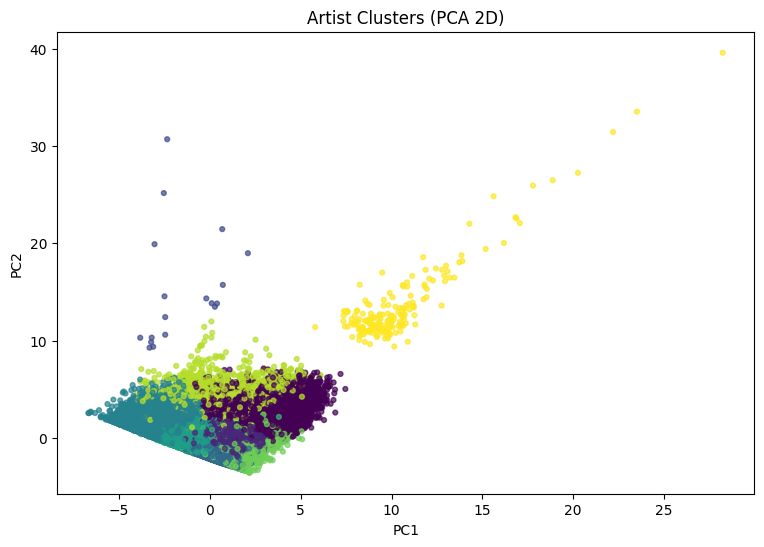

In [11]:
cluster_runner = ArtistClusteringRunner(
    k=int(best_cluster_cfg["k"]),
    seed=RANDOM_SEED,
    scale=bool(best_cluster_cfg["scale"]),
    pca_dim=int(best_cluster_cfg["pca_dim"]),
)
cluster_models, cluster_artifact, cluster_extra = cluster_runner.run(data.artist_df)

# optional plot on sample
cluster_runner.plot_pca2(cluster_extra["X_used"], cluster_extra["labels"])


##  Embeddings & Track Similarity: Plausibilitäts-Checks

Track-Similarity ist in der Praxis oft **qualitativ** zu bewerten (klingen/fühlen sich die Nachbarn ähnlich an?).
Hier führen wir daher einen stabilen Check durch:

- Embedding einmal fitten
- Mehrere **gültige Track-Keys** auswählen
- Für jeden Key die Top-K ähnlichsten Tracks abrufen

Ziel: Sicherstellen, dass die Pipeline funktioniert, die Keys korrekt gematcht werden und die Ergebnisse plausibel sind.


In [12]:
sim_runner = TrackSimilarityRunner()
sim_models, sim_artifact = sim_runner.fit(data.track_df)

track_keys = data.track_df.index.to_numpy()
RNG = np.random.RandomState(RANDOM_SEED)
example_keys = RNG.choice(track_keys, size=5, replace=False)

# column that contains the title
title_col = "name"   # adjust if needed

def add_titles(similar_list):
    """similar_list: [(track_key, score), ...] -> [(track_key, title, score), ...]"""
    out = []
    for k, score in similar_list:
        # pull title by index
        try:
            t = data.track_df.loc[k, title_col]
        except Exception:
            t = None
        out.append((k, t, float(score)))
    return out

examples_with_titles = {}

for key in example_keys:
    sims = sim_runner.get_similar(
        track_key=key,
        track_index=data.track_df.index,
        embeddings=sim_models["embeddings"],
        top_k=3

    )

    # also include the query track title
    query_title = data.track_df.loc[key, title_col] if title_col in data.track_df.columns else None

    examples_with_titles[str(key)] = {
        "query": {"track_key": key, "title": query_title},
        "similar": add_titles(sims)
    }

examples_with_titles

{'206366': {'query': {'track_key': np.int64(206366), 'title': 'I Do'},
  'similar': [(139397, 'Open Up', 0.9918463852456849),
   (35302, 'Yorgunum Kaptan', 0.9898749484238405),
   (182381, '(Lovely Day For A) Parade', 0.9862959723941351)]},
 '257671': {'query': {'track_key': np.int64(257671),
   'title': 'Ennek A Kislánynak - Medley'},
  'similar': [(35202, 'Andere Zeiten', 0.9954536142349157),
   (104702, 'Rice, Beans', 0.9920353940542102),
   (258922, 'Midi Velocity', 0.9892536930155154)]},
 '199424': {'query': {'track_key': np.int64(199424),
   'title': "Hoedown's / Leather Britches / Sally Goodin' - Remastered"},
  'similar': [(151679,
    'Variations sur Casse-Noisette: V. Trepak',
    0.993291460994772),
   (184766, 'Indian Boogie Woogie (Rhythmus In Indien)', 0.9886166862262761),
   (81301, 'Di Zilberne Khasene', 0.9883534552264343)]},
 '125920': {'query': {'track_key': np.int64(125920),
   'title': 'Mimaméta: Mimaméta'},
  'similar': [(77079, 'Average Fruit (MeLo-X GodMix)', 0.

## Finalisierung: Best-Modelle retrainen & Artefakte speichern

Jetzt retrainen wir jedes Modell mit den **besten gefundenen Hyperparametern** und speichern:

- Modelle nach `PATHS.tuned_models_dir`
- Tuning-Report (Scores + Parameter + Artefakte) nach `PATHS.reports_dir_tuned`

Damit ist die Tuning-Runde reproduzierbar und die Ergebnisse sind sauber versioniert.


In [16]:
tuned_report = {}
# success_pct
pct_model, pct_metrics = pct_trainer.fit_eval(ds_pct,best_pct["best_params"])
save_joblib({"model": pct_model, "best_params": best_pct}, PATHS.tuned_models_dir / "success_pct_tuned.joblib")
tuned_report["success_pct"] = {"best": best_pct, "metrics": pct_metrics}

# success_residual
res_model, res_metrics = res_trainer.fit_eval(ds_res,best_res["best_params"])
save_joblib({"model": res_model, "best_params": best_res}, PATHS.tuned_models_dir / "success_residual_tuned.joblib")
tuned_report["success_residual"] = {"best": best_res, "metrics": res_metrics}

# hit
hit_model, hit_metrics, hit_thr = hit_trainer.fit_eval(ds_hit, params=best_hit["best_params"])
save_joblib({"model": hit_model, "threshold": hit_thr, "best_params": best_hit}, PATHS.tuned_models_dir / "hit_tuned.joblib")
tuned_report["hit"] = {"best": best_hit, "metrics": hit_metrics}

# mood (optional)
if best_mood is not None:
    thr = best_mood["best_params"].pop("threshold", 0.5)   # remove + keep value
    best_mood["best_threshold"] = thr                      # store separately
    mood_model, mood_metrics, mood_thresholds = mood_trainer.fit_eval(ds_mood, params=best_mood["best_params"])
    save_joblib({"model": mood_model,  "best_params": best_mood}, PATHS.tuned_models_dir / "mood_tuned.joblib")
    tuned_report["mood"] = {"best": best_mood, "metrics": mood_metrics}

# ranker (optional)
if "best_rank" in globals() and best_rank is not None:
    rank_model, rank_metrics = rank_trainer.fit_eval(ds_pct, params=best_rank["best_params"])
    save_joblib({"model": rank_model, "best_params": best_rank}, PATHS.tuned_models_dir / "ranker_tuned.joblib")
    tuned_report["ranker"] = {"best": best_rank, "metrics": rank_metrics}

# artist clustering (save fitted full model)
save_joblib({"models": cluster_models, "artifact": cluster_artifact, "best_cfg": best_cluster_cfg},
            PATHS.tuned_models_dir / "artist_clustering_tuned.joblib")
tuned_report["artist_clustering"] = {"best_cfg": best_cluster_cfg, "artifact": cluster_artifact}

# track similarity (save embedding)
save_joblib({"models": sim_models, "artifact": sim_artifact}, PATHS.tuned_models_dir / "track_similarity.joblib")
tuned_report["track_similarity"] = sim_artifact

# final tuned report json
tuned_report["run_config"] = {"seed": RANDOM_SEED, "allow_leaky_features": ALLOW_LEAKY_FEATURES}
save_json(tuned_report, PATHS.reports_dir_tuned / "tuned_metrics_report.json")

tuned_report.keys()


dict_keys(['success_pct', 'success_residual', 'hit', 'mood', 'ranker', 'artist_clustering', 'track_similarity', 'run_config'])